## Lab 3

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [0]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [0]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [28]:
# Join all the strings into one and lowercase it
# Put result into variable text.
text = ''.join(text).lower()
# Your great code here
assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [9]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2020-05-25 20:19:31--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.2’

onegin.txt.2        100%[===================>] 256.37K  --.-KB/s    in 0.02s   

2020-05-25 20:19:31 (15.0 MB/s) - ‘onegin.txt.2’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [0]:
# Join all the strings into one and lowercase it
# Put result into variable text.
text = ''.join(text).lower()
# Your great code here


Put all the characters, that you've seen in the text, into variable `tokens`.

In [0]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [0]:
# dict <index>:<char>
idx_to_token = {i: tokens[i] for i in range(len(tokens))}

# dict <char>:<index>
token_to_idx = {tokens[i]: i for i in range(len(tokens))}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
from tqdm import tqdm_notebook as tqdm


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [0]:
class RNN(nn.Module):
    def __init__(self, in_size, hidden_size, out_size=None):
        super(RNN, self).__init__()
        if out_size is None:
            out_size = in_size
        
        self.rnn = nn.RNN(in_size, hidden_size)
        self.o2y = nn.Linear(hidden_size, out_size)
        
        self.hidden_size = hidden_size
    
    def forward(self, x, h):
        o, h = self.rnn(x, h)
        y = self.o2y(o.view(-1, self.hidden_size))
        return y, h

In [0]:
def token_to_vector(c):
    v = torch.zeros(len(tokens))
    v[token_to_idx[c]] = 1
    return v

def vector_to_token(v):
    return idx_to_token[torch.argmax(v).item()]

In [33]:
text_vector = torch.cat([token_to_vector(c).unsqueeze(0) for c in text], dim=0)
text_idx = torch.cat([torch.LongTensor([token_to_idx[c]]) for c in text], dim=0)

KeyError: ignored

In [0]:
def get_batch(batch_size=128, length=512):
    starts = torch.randint(len(text) - length, (batch_size,))
    x = torch.cat([text_vector[s:s+length].unsqueeze(1) for s in starts], dim=1)
    y = torch.cat([text_idx[s+1:s+1+length].unsqueeze(1) for s in starts], dim=1)
    return x, y

In [0]:
def train_rnn_net(net, lr=0.001, n_epoch=20, batch_size=128, clip_grad=False, second_hidden=False):
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss().to(device)
    losses = []
    net = net.to(device)
    net.train()
    for epoch in tqdm(range(n_epoch)):
        opt.zero_grad()
        h = torch.zeros(1, batch_size, net.hidden_size, device=device)
        if second_hidden:
            c = torch.zeros(1, batch_size, net.hidden_size, device=device)
        x, y = get_batch(batch_size)
        x, y = x.to(device), y.to(device)
        if not second_hidden:
            output, h_new = net(x, h)
        else:
            output, (h_new, c_new) = net(x, (h, c))
        loss = criterion(output, y.view(-1))
        loss.backward()
        losses.append(loss.data.item())
        if clip_grad:
            grad = nn.utils.clip_grad_norm_(net.parameters(), max_norm=1)
        opt.step()
    plt.figure(figsize=(15, 7))
    plt.plot(losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(c='grey')
    plt.show()

In [0]:
def gen_token(v, temperature):
    probs = nn.Softmax(dim=0)(v / temperature)
    left = torch.rand(())
    idx = 0
    for i, p in enumerate(probs):
        left -= p
        if left < 0:
            idx = i
            break
    return idx_to_token[idx]

def generate_text(net, length=500, temperature=1, second_hidden=False):
    out = ''    
    net = net.to(device)
    net.eval()
    h = torch.zeros(1, 1, net.hidden_size, device=device)
    if second_hidden:
        c = torch.zeros(1, 1, net.hidden_size, device=device)
    token = '\n'
    for i in range(length - 1):
        x = token_to_vector(token).unsqueeze(0).unsqueeze(0).to(device)
        if not second_hidden:
            v, h = net(x, h)
        else:
            v, (h, c) = net(x, (h, c))
        token = gen_token(v.squeeze(0).squeeze(0), temperature)
        out += token
    return out

In [0]:
def print_generated(net, length=500, ts=[0.1, 0.2, 0.5, 1.0, 2.0], second_hidden=False):
    for t in ts:
        print('\n===== Temperature: {:.1f} ====='.format(t))
        print(generate_text(net, length=length, temperature=t, second_hidden=second_hidden))

Plot the loss function (axis X: number of epochs, axis Y: loss function).

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


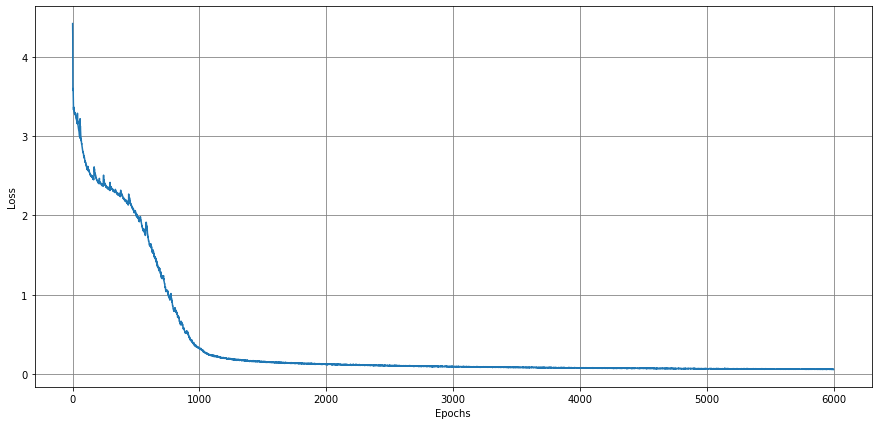

In [38]:
rnn = RNN(len(tokens), 1024)
train_rnn_net(rnn, n_epoch=6000)

In [39]:
# An example of generated text.
print(generate_text(rnn, length=500, temperature=0.001))




xx

домой приехав, пистолеты
он осмотрел, потом вложил
опять их в ящик и, раздетый,
при свечке, шиллера открыл;
но мысль одна его объемлет;
в нем сердце грустное не дремлет:
с неизъяснимою красой
он видит ольгу пред собой.
владимир книгу закрывает,
берет перо; его стихи,
полны любовной чепухи,
звучат и льются. их читает
он вслух, в лирическом жару,
как дельвиг пьяный на пиру.



xxi

стихи на случай сохранились;
я их имею; вот они:
«куда, куда вы удалились,
весны моей златые дни?
что день гр


In [45]:
print_generated(rnn)


===== Temperature: 0.1 =====



xx

домой приехав, пистолеты
он осмотрел, потом вложил
опять их в ящик и, раздетый,
при свечке, шиллера открыл;
но мысль одна его объемлет;
в нем сердце грустное не дремлет:
с неизъяснимою красой
он видит ольгу пред собой.
владимир книгу закрывает,
берет перо; его стихи,
полны любовной чепухи,
звучат и льются. их читает
он вслух, в лирическом жару,
как дельвиг пьяный на пиру.



xxi

стихи на случай сохранились;
я их имею; вот они:
«куда, куда вы удалились,
весны моей златые дни?
что день гр

===== Temperature: 0.2 =====



xx

домой приехав, пистолеты
он осмотрел, потом вложил
опять их в ящик и, раздетый,
при свечке, шиллера открыл;
но мысль одна его объемлет;
в нем сердце грустное не дремлет:
с неизъяснимою красой
он видит ольгу пред собой.
владимир книгу закрывает,
берет перо; его стихи,
полны любовной чепухи,
звучат и льются. их читает
он вслух, в лирическом жару,
как дельвиг пьяный на пиру.



xxi

стихи на случай сохранились;
я их имею; вот они:
«

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [0]:
class LSTM(nn.Module):
    def __init__(self, in_size, hidden_size, out_size=None):
        super(LSTM, self).__init__()
        if out_size is None:
            out_size = in_size
        
        self.lstm = nn.LSTM(in_size, hidden_size)
        self.o2y = nn.Linear(hidden_size, out_size)
        
        self.hidden_size = hidden_size
    
    def forward(self, x, h):
        o, h = self.lstm(x, h)
        y = self.o2y(o.view(-1, self.hidden_size))
        return y, h

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


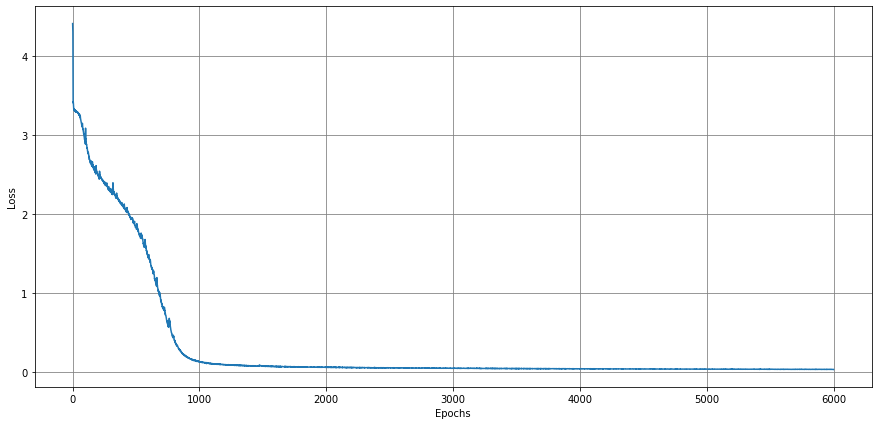

In [41]:
lstm = LSTM(len(tokens), 1024)
train_rnn_net(lstm, n_epoch=6000, second_hidden=True)

In [44]:
print_generated(lstm, second_hidden=True)


===== Temperature: 0.1 =====



xxxii

мое сморинья, в том су согом
вамят ножет летской невнил:

о нег ренувиж ная небой
был жертвой ворный с похорвнимиче
пыседом, мно нега яный»
та вравится раз мледы; друг ергений,
и в радамся горто и мутела,
по толпом онегин с оводой
одно б дасномась и тепец

пескум и млогом раастилась
давалья вмочно, полов давнлон,
кокмин мудови холлаядо
не моляной свлестью пасьяна
гоступинием я нести:
мне наш онегин бод шелкой
мажьен елегин п петьша мой
усод на света бел госое
итсе ж о вздохох толашой,

===== Temperature: 0.2 =====



xxxii

но ни, есе всемда жало
пачтинный дог встантых аня снеща,
у дане другил и хранела
и замлиг толся тви говор
ноурож не выт пилиней,
жевальной мустья другой,
вошнай ибеглам и педать,
не молянит пельта с маюбой,
не минят ват, там душькой волнель,
и помли та сего пере
ланя, горторьюных пистя,
в глуше звоет и метуд.
знак узоалать н улебе други,
пол довой равеет и овлад
олал он просте ведитай
их а титем у рачай дане
катичат каб ужет д

LSTM справилась с задачей не сильно лучше обычной RNN(что странно), лосс получился не сильно меньше, на обучение ушло в 4 раза больше времени. Текст получился более правдоподобным и связным, длина строк стала из того же распределения, как и в исходном тексте (в случае обычной RNN распределение получилось не совсем таким - были очень длинные строки).
При низкой температуре генерируется текст, максимально похожий на исходный (при очень низкой - идентичный исходному, если сеть его заучила). При средней температуре текст становится более разнообразным, но по-прежнему похож на исходный. При высокой температуре текст становится более хаотичным: длина строк варьируется сильнее, появляются обрывки слов, ломается синтаксис.

In [0]:
def analize_lengths(text):
    lengths = np.array([len(s) for s in text.split('\n')])
    lengths_sample = lengths[:400]

    plt.figure(figsize=(12, 3))
    plt.hist2d(range(len(lengths_sample)), lengths_sample, bins=(400, 30))
    plt.xlabel('Position in data')
    plt.ylabel('Line length')
    plt.show()

    lengths.sort()
    uls, counts = np.unique(lengths, return_counts=True)

    plt.figure(figsize=(12, 4))
    plt.scatter(uls, counts)
    plt.xlabel('Line length')
    plt.ylabel('Frequency')
    plt.show()

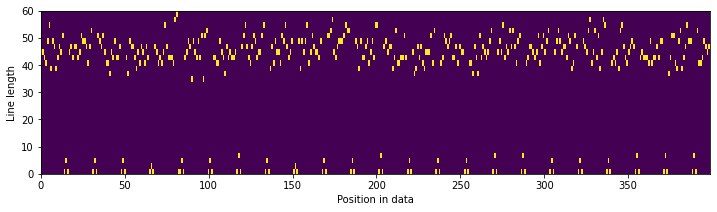

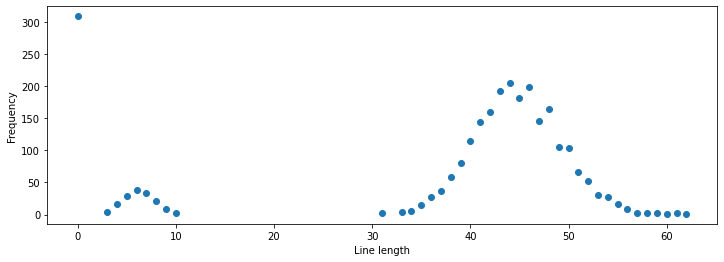

In [48]:
analize_lengths(text)

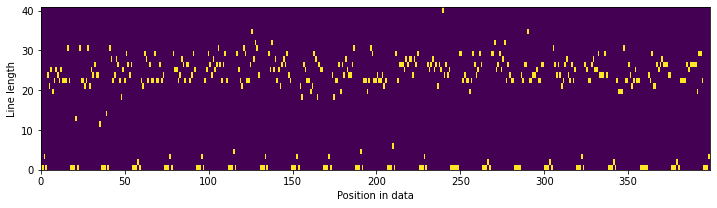

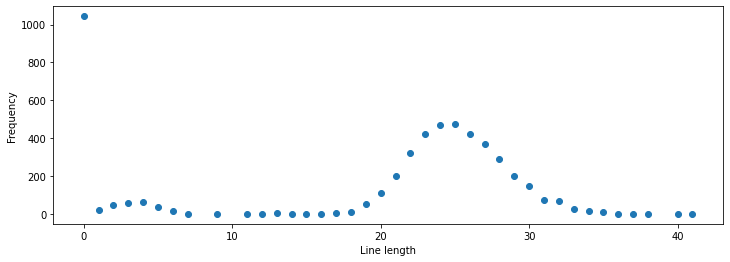

In [60]:
analize_lengths(generate_text(lstm, length = 2000 * 50, temperature=0.25, second_hidden=True))

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [0]:
import pickle
file_name = 'lstm_trained.dat'

In [61]:
pickle.dump(lstm.state_dict(), open(file_name, 'wb'))

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [62]:
lstm_loaded = LSTM(len(tokens), 1024)
lstm_loaded.load_state_dict(pickle.load(open(file_name, 'rb')))

<All keys matched successfully>

In [64]:
print(generate_text(lstm_loaded, length=500, temperature=0.2, second_hidden=True))




xxxii

но ни, есе всемда жале
парцет меля брадениа свок.



xiv

увылать в дома о немирать,
запосливью похлужинся ограммии
гореетревной сам и похновый,
ди островол и замеру,
на молча онегим поскакал.
перед померкшими домами
вдоль сонной улицы рядами
двойные фонари карет
веселый изливают свет
и радуги на снег наводят;
усеян плошками кругом,
блестит великолепный дом;
по цельным окнам тени ходят,
мелькают профили голов
и дам и модных чудаков.



xxviii

вот наш герой подъехал к сеням;
швейцара 


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)